# LSTM: Long Short-Term Memory
> - 단기 기억을 오래 기억하기 위해 고안

### 구조
> - 입력과 가중치를 곱하고 절편을 더해 활성화 함수를 통과시키는 구조를 여러 개 가지고 있다.
> - 계산 결과는 타임스텝에서 재사용

### 은닉 상태
> - 입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시켜 다음 은닉 상태를 만든다.
> - 시그모이드 활성화 함수 사용
> - 순환되는 상태 2개 -> 은닉 상태 + 셀 상태
> - 셀 상태 = 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값

In [2]:
from tensorflow.keras.datasets import imdb
from sklearn.model_selection import train_test_split
import numpy as np


(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

In [3]:
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)


lengths = np.array([len(x) for x in train_input])
np.mean(lengths), np.median(lengths)

(239.00925, 178.0)

In [5]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


train_seq = pad_sequences(train_input, maxlen=100)
val_seq = pad_sequences(val_input, maxlen=100)

val_seq.shape, train_seq.shape

((5000, 100), (20000, 100))

In [8]:
from tensorflow import keras

model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100)) 
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.build(input_shape=(None, 100))

In [9]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,809 (34.41 KB)

 Trainable params: 8,809 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-LSTM-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5370 - loss: 0.6926 - val_accuracy: 0.5782 - val_loss: 0.6912
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5917 - loss: 0.6903 - val_accuracy: 0.6086 - val_loss: 0.6878
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6172 - loss: 0.6862 - val_accuracy: 0.6254 - val_loss: 0.6803
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6401 - loss: 0.6767 - val_accuracy: 0.6518 - val_loss: 0.6630
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6681 - loss: 0.6527 - val_accuracy: 0.7002 - val_loss: 0.6116
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7164 - loss: 0.5818 - val_accuracy: 0.7494 - val_loss: 0.5377
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7483 - loss: 0.5255 - val_accuracy: 0.7602 - val_loss: 0.5102
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7677 - loss: 0.4988 - 

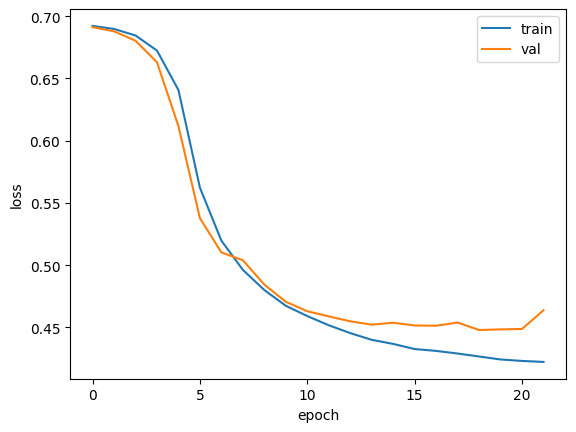

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

## dropout
> - 셀의 입력에 드롭아웃을 적용

## recurrent_dropout
> - 순환되는 은닉 상태에 드롭아웃을 적용 -> GPU를 사용해 모델을 훈련하지 못 한다 -> 훈련 속도가 크게 느려진다.

In [13]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.build(input_shape=(None, 100))

In [14]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-LSTM-dropout-model.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5242 - loss: 0.6928 - val_accuracy: 0.5712 - val_loss: 0.6920
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5641 - loss: 0.6916 - val_accuracy: 0.6044 - val_loss: 0.6903
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6002 - loss: 0.6891 - val_accuracy: 0.6310 - val_loss: 0.6862
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6185 - loss: 0.6844 - val_accuracy: 0.6460 - val_loss: 0.6758
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.6577 - loss: 0.6685 - val_accuracy: 0.7054 - val_loss: 0.6268
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7062 - loss: 0.6072 - val_accuracy: 0.7262 - val_loss: 0.5702
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7264 - loss: 0.5641 - val_accuracy: 0.7426 - val_loss: 0.5446
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7379 - loss: 0.5464 - 

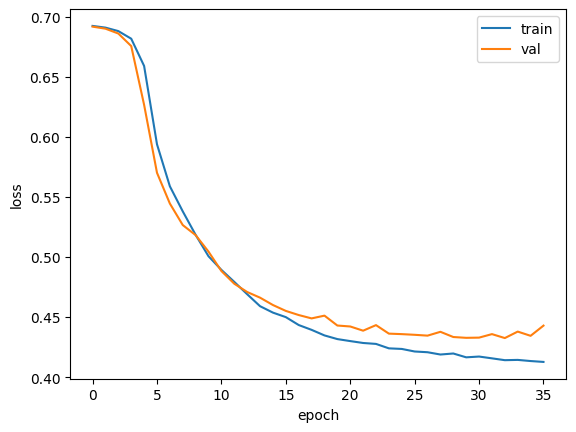

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# 두 개 층 연결

> - 순환층의 은닉 상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음 층으로 전달
> - 하지만 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요
> - 앞쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력해야 한다.
> - 마지막 순환층만이 마지막 타임스텝의 은닉 상태를 출력해야 한다.

### 순환층에서 모든 타임스텝의 은닉 상태를 출력하려면 return_sequences 매개변수를 True

In [19]:
model3 = keras.Sequential()

model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.build(input_shape=(None, 100))

In [20]:
model3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 100, 8)         │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 8)              │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,353 (36.54 KB)

 Trainable params: 9,353 (36.54 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-LSTM-dropout-model2.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model3.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.5499 - loss: 0.6919 - val_accuracy: 0.5426 - val_loss: 0.6905
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5802 - loss: 0.6880 - val_accuracy: 0.6600 - val_loss: 0.6732
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.6201 - loss: 0.6597 - val_accuracy: 0.6920 - val_loss: 0.6047
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6957 - loss: 0.5978 - val_accuracy: 0.7184 - val_loss: 0.5744
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7219 - loss: 0.5671 - val_accuracy: 0.7368 - val_loss: 0.5393
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7489 - loss: 0.5331 - val_accuracy: 0.7496 - val_loss: 0.5173
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7489 - loss: 0.5202 - val_accuracy: 0.7612 - val_loss: 0.5005
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.7699 - loss: 0.4986 - 

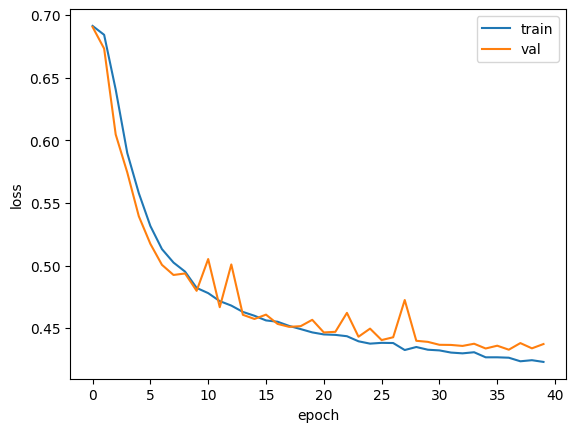

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

# GRU
> - LSTM을 간소화한 버전
> - 셀 상태를 계산하지 않고 은닉 상태 하나만 포함
> - LSTM보다 가중치가 적어 계산량이 적지만 LSTM 못지않은 성능을 보여준다.

In [27]:
model4 = keras.Sequential()

model4.add(keras.layers.Embedding(500, 16, input_length=100))
model4.add(keras.layers.GRU(8))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

model4.build(input_shape=(None, 100))

In [28]:
model4.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 16)        │         8,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 8)              │           624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,633 (33.72 KB)

 Trainable params: 8,633 (33.72 KB)

 Non-trainable params: 0 (0.00 B)

> - 입력 = 16
> - 가중치 = 8
> - 은닉 상태에 곱하는 가중치 = 8 * 8
> - 절편은 뉴런마다 하나씩 = 8
>
> - GRU 셀에는 3개의 작은 셀이 있다.
> - 128 + 64 + 8 = 200
> - 200 * 3 =600
>
> - 작은 셀마다 하나씩 절편, 8개의 뉴런 -> 24개의 절편

In [29]:
rmsprop = keras.optimizers.RMSprop(learning_rate=1e-4)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-LSTM-dropout-model2.keras', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model4.fit(train_seq, train_target, epochs=100, batch_size=64, validation_data=(val_seq, val_target), callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.4976 - loss: 0.6930 - val_accuracy: 0.5418 - val_loss: 0.6919
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5658 - loss: 0.6913 - val_accuracy: 0.5882 - val_loss: 0.6898
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6046 - loss: 0.6888 - val_accuracy: 0.6082 - val_loss: 0.6864
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6168 - loss: 0.6851 - val_accuracy: 0.6152 - val_loss: 0.6809
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6339 - loss: 0.6779 - val_accuracy: 0.6328 - val_loss: 0.6712
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6423 - loss: 0.6667 - val_accuracy: 0.6516 - val_loss: 0.6548
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6611 - loss: 0.6469 - val_accuracy: 0.6852 - val_loss: 0.6229
Epoch 8/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6979 - loss: 0.6064 - 

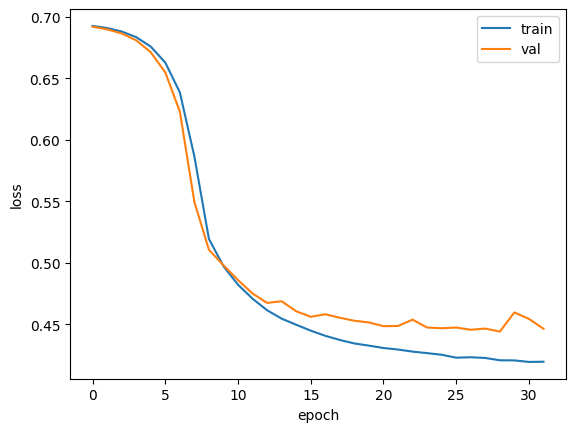

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [31]:
test_seq = pad_sequences(test_input, maxlen=100)
rnn_model = keras.models.load_model('best-LSTM-dropout-model2.keras')
rnn_model.evaluate(test_seq, test_target)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7981 - loss: 0.4403


[0.4404374361038208, 0.7964400053024292]